In [1]:
import numpy as np  # for numerical pyhton libraries
import pandas as pd
from scipy import stats as st

import seaborn as sns
import matplotlib.pyplot as plt  # for plotting
import numpy.matlib

In [2]:
file_length = []
for m in range(1, 51):
    
    X = pd.read_csv('Data/Data{}.csv'.format(m), names = ['x11', 'x12', 'x13'])
    file_length.append(len(X))
    

In [3]:
#create x dataframe storing all information from each sequence
S=len(file_length) #number of sequence
time_max=max(file_length)

x1=np.zeros((time_max, S))
x2=np.zeros((time_max,S))
x3=np.zeros((time_max,S))

for s in range(0,S):
    X = pd.read_csv('Data/Data{}.csv'.format(s+1), names = ['X1', 'X2', 'X3'])
    time=X.shape[0]
    x1[:time,s]=X['X1']
    x2[:time,s]=X['X2']
    x3[:time,s]=X['X3']
    

In [4]:
# for generating an initial guess
def InitialParamGuess(x1,x2,x3, K):
    
    mu = x1.mean()
    sigma = np.std(x1)
    lambd = 1/x2.mean()
    unique, counts = np.unique(x3, return_counts=True)
    cat = counts/sum(counts)
    
    # add some noise
    epsilon = 0.05
    mu *= np.sort(np.exp(epsilon * np.random.randn(K)))
    sigma *= np.exp(epsilon * np.random.randn(K))
    lambd *= np.exp(epsilon * np.random.randn(K))
    cat = np.tile(cat,(K,1))

    pi = np.ones(K) / K
    pi *= np.exp(epsilon * np.random.randn(K))
    pi /= np.sum(pi)
    
    A = np.ones((K,K)) / K
    for i in range(K):
        
        A[i,:] *= np.exp(epsilon * np.random.randn(K))
        A[i,:] /= np.sum(A[i,:])

    return pi, A, mu, sigma, lambd, cat

In [5]:
def psi1(x, mu, sigma):
    
    
    return st.norm.pdf(x,mu, sigma)
    #np.exp(-0.5* ((x-mu)/sigma)**2 ) / (np.sqrt(2*np.pi)*sigma)

In [6]:
def psi2(x,lambd):
    
    
    return lambd * np.exp(-x * lambd) 

In [7]:
def psi3(x,j, cat):
    
    return cat[j,int(x-1)]

In [8]:
def psi(x, mu, sigma, lambd, cat):
    
    # x is 3D
    
    return st.norm.pdf(x[0],mu, sigma) \
            * lambd * np.exp(-x[1] * lambd) \
            * cat[:,int(x[2]-1)]

In [9]:
def forwardFilter(X, pi, A, mu, sigma, lambd, cat):

    K = pi.shape[0]
    N = X.shape[0]
        
    alpha = np.zeros((K,N)) 
    eta = np.zeros(N) 
    
    # initialize filter
    alpha[:,0] = psi(X[0], mu, sigma, lambd, cat) * pi

    eta[0] = np.sum(alpha[:,0])        
    alpha[:,0] /= eta[0]
    
    # step forward in time    
    for t in range(1,N):
        
        alpha[:,t] = psi(X[t], mu, sigma, lambd, cat) * np.matmul( A.T,alpha[:,t-1] )
    
        eta[t] = np.sum(alpha[:,t])
        alpha[:,t] /= eta[t]
    
    return eta, alpha

In [10]:
def backwardFilter(X, eta, pi, A, mu, sigma, lambd, cat):
    
    K = pi.shape[0]
    N = X.shape[0]
    
    beta = np.zeros((K,N))
    
    beta[:,-1] = 1
    
    for t in range(N-2,-1,-1):
        beta[:,t] = np.matmul(A, beta[:,t+1] * psi(X[t+1], mu, sigma, lambd, cat) ) / eta[t+1]
        
    return beta

In [11]:
#perform the e-step
def estep(x1, x2, x3, pi, A, mu, sigma, lambd, cat,file_length):
    
    K = pi.shape[0]
    
    max_length = max(file_length)
    
    alpha = np.zeros((K, max_length,len(file_length)))
    eta = np.zeros((max_length,len(file_length)))
    beta = np.zeros((K, max_length,len(file_length)))
    gamma = np.zeros((K, max_length,len(file_length)))
    xi = np.zeros((K, K, max_length-1,len(file_length)))

    for m in range(0, len(file_length)):


        X = pd.DataFrame({'x1': x1[:,m], 'x2': x2[:,m], 'x3': x3[:,m]}).iloc[:file_length[m],:]
        X = X.values
        
        
        eta_m, alpha_m = forwardFilter(X, pi, A, mu, sigma, lambd, cat)
        eta[:len(X),m], alpha[:,:len(X),m] = eta_m, alpha_m

        beta_m = backwardFilter(X, eta_m, pi, A, mu, sigma, lambd, cat)
        beta[:,:len(X),m] = beta_m
        
        gamma[:,:,m] = alpha[:,:,m] * beta[:,:,m]
        
        for i in range(K):
            for j in range(K):

                psij = np.zeros(len(X)-1)
                psij = psi1(X[1:,0], mu[j], sigma[j])\
                        *psi2(X[1:,1],lambd[j])\
                        *np.array([psi3(x,j,cat) for x in X[1:,2]])


                xi[i,j,:len(X)-1,m] = alpha_m[i,:-1] * A[i,j] * psij * beta_m[j,1:] / eta_m[1:]
       
    return eta, gamma, xi , alpha  ,beta 




In [12]:
#perform the m-step
def mstep(x1,x2,x3, gamma, xi,file_length):
    
    K = gamma.shape[0]
    
    # update pi
    pi = np.sum(gamma[:,0,:],axis=1) #sum all time step
    pi /= np.sum(pi) #normalized the results by summing all latent' result
    
    # update A, mu, sigma, lambda
    
    A = np.zeros((K,K))
    mu = np.zeros(K)    
    sigma = np.zeros(K)
    lmbda=np.zeros(K)
    
    cat=np.zeros((K,5))   

    
    for i in range(K):
        
        #update A
        for j in range(K):
            
            #kris:
            num=0
            de=0
            for m in range(0, len(file_length)):
                if file_length[m]!=max(file_length):
                    
                    num +=np.sum(xi[i,j,: file_length[m]-1,m])
                else:
                    num +=np.sum(xi[i,j,:,m])
                de += np.sum(gamma[i,:file_length[m]-1,m])
                    
            A[i,j]=num/de
                
        #update model parameters

        nrm_fac = np.sum(gamma[i,:,:], axis = None)  #可同时用于mu, sigma, lambda的update

        mu[i] = np.sum(gamma[i,:,:] * x1, axis = None)/nrm_fac
        sigma[i] = np.sqrt(np.sum(gamma[i,:,:] * (x1-mu[i])**2, axis = None) / nrm_fac)

        lmbda[i]=nrm_fac/ np.sum(gamma[i,:,:]* x2, axis=None)

        for c in range(5):
            mask=np.array(x3==c+1)*1     #find all x3=c+1
            num=np.sum(gamma[i,:,:]* mask,axis=None)
            de=np.sum(gamma[i,:,:],axis=None)
            cat[i,c]=num/de

    return pi, A, mu, sigma,lmbda,cat

In [13]:
#perform EM:
def EM(x1,x2,x3, MAX_ITER, K):
 
    pi0, A0, mu0, sigma0, lmbda0, cat0= InitialParamGuess(x1,x2,x3, K)
    
    pi = [] 
    A = []
    mu = []
    sigma = []
    lmbda=[]
    cat=[]
    
    pi.append(pi0)
    A.append(A0)
    mu.append(mu0)
    sigma.append(sigma0)
    lmbda.append(lmbda0)
    cat.append(cat0)
    
    
    for i in range(MAX_ITER):
          
        # perform e-step
        eta, gamma, xi, alpha, beta=estep(x1, x2, x3, pi[i], A[i], mu[i], sigma[i], lmbda[i], cat[i], file_length)
        
        # peform m-step
        pi_new , A_new, mu_new, sigma_new, lmbda_new, cat_new = mstep(x1,x2,x3, gamma, xi, file_length)
        
        # add in results
        pi.append(pi_new)
        A.append(A_new)
        mu.append(mu_new)
        sigma.append(sigma_new) 
        lmbda.append(lmbda_new)
        cat.append(cat_new)

    
    return pi, A, mu, sigma, lmbda, cat



In [14]:
#using BIC to select the best model:
def BIC(K, MAX_ITER):
    
    pi, A, mu, sigma, lmbda, cat= EM(x1,x2,x3, MAX_ITER, K)
    
    S=len(file_length)
    ll=0
    
    for s in range(S):
        X = pd.read_csv('Data/Data{}.csv'.format(s+1), names = ['X1', 'X2', 'X3'])
        X = X.values
        eta,alpha=forwardFilter(X, pi[-1], A[-1], mu[-1], sigma[-1], lmbda[-1], cat[-1])

        ll+=np.sum(np.log(eta))
        
        
    d=K*(3+(5-1))+(K-1)+K*(K-1)
    bic= -ll+0.5*d * np.log(sum(file_length))
    return bic
        

Text(0.5, 0, '$Regimes$')

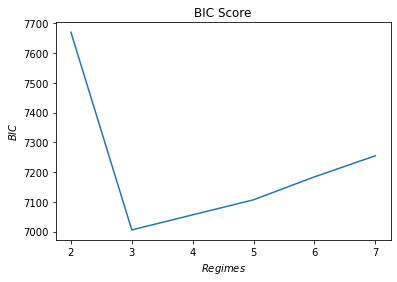

In [16]:
Kfit_list=np.arange(2,8,1)
bic_list=[]
for k in Kfit_list:
    bic_list.append(BIC(k,100))
    
 #plot the result
plt.plot(Kfit_list,bic_list)
plt.title('BIC Score')
plt.ylabel(r'$BIC$')
plt.xlabel(r'$Regimes$')

## Question3: 
From the learnt model, use the bootstrap approach to generate new samples and re-estimate the model to determine confidence bands on the learnt parameters. Generate 20 re-estimations.

In [15]:
def Simdata(pi, A, mu, sigma, lmbda, cat):
    
    time_max=max(file_length)
    S=len(file_length)

    a1=np.zeros((time_max,S))
    a2=np.zeros((time_max,S))
    a3=np.zeros((time_max,S))

    for s in range(S):

        length=file_length[s]

        Y=np.zeros(length).astype(int)
        X=np.zeros((3,length))

        cs_A = np.cumsum(A,axis=1)
        cs_pi = np.cumsum(pi)

        # draw from the prior

        
        Y[0]=np.sum(np.random.rand()>cs_pi)
        
        for t in range(length):
            
            # generate X1:normal
            X[0,t] = mu[Y[t]] + sigma[Y[t]] * np.random.randn()
            #generate x2:exp
            X[1,t] = -np.log(np.random.rand())/lmbda[Y[t]]
            #generate x3
            cs_cat=np.cumsum(cat,axis=1)
            X[2,t]=np.sum(np.random.rand()>cs_cat[Y[t]]) + 1

            # update Y
            if t < length-1:
                U = numpy.matlib.repmat(np.random.rand(),1,pi.shape[0])
                Y[t+1] = np.sum(U > cs_A[Y[t],:], axis=1) 

        a1[:length,s]=X[0,:]
        a2[:length,s]=X[1,:]
        a3[:length,s]=X[2,:]

    return a1,a2,a3 



In [16]:
#bootstrap to generate 20 new samples
pi_new=[]
A_new=[]
mu_new=[]
sigma_new=[]
lmbda_new=[]
cat_new=[]

pi0, A0, mu0, sigma0, lmbda0, cat0= EM(x1,x2,x3, 50, 3)

for i in range(20):
    
    a1,a2,a3=Simdata(pi0[-1],A0[-1],mu0[-1],sigma0[-1],lmbda0[-1],cat0[-1])
    
    pi1, A1, mu1, sigma1, lmbda1, cat1= EM(a1,a2,a3, 50, 3)

    pi_new.append(np.array([pi1[-1] for _, pi1[-1] in sorted(zip(lmbda1[-1],pi1[-1]))]))
    
    first=[A1[-1] for _, A1[-1] in sorted(zip(lmbda1[-1],A1[-1]))]
    for j in range(3):
        first[j]=[first[j] for _, first[j] in sorted(zip(lmbda1[-1],first[j]))]
    A_new.append(np.array(first))
    mu_new.append(np.array([mu1[-1] for _, mu1[-1] in sorted(zip(lmbda1[-1],mu1[-1]))]))
    sigma_new.append(np.array([sigma1[-1] for _, sigma1[-1] in sorted(zip(lmbda1[-1],sigma1[-1]))]))
    cat_new.append(np.array([cat1[-1] for _, cat1[-1] in sorted(zip(lmbda1[-1],cat1[-1]))]))
    lmbda1[-1].sort()
    lmbda_new.append(lmbda1[-1])





In [17]:
#lmbda_new

[array([ 0.98290792,  4.98819614, 18.66680111]),
 array([ 0.9834473 ,  5.26555046, 20.45358922]),
 array([ 0.97325232,  5.04851835, 19.15449147]),
 array([ 1.01911644,  5.04049987, 19.25283562]),
 array([ 1.00192216,  5.05164899, 18.89113597]),
 array([ 1.00606438,  5.53372802, 19.12713904]),
 array([ 0.93628416,  2.72312497, 12.46670912]),
 array([ 1.00704688,  4.63516227, 18.36880084]),
 array([ 0.99800606,  4.74539967, 19.63698208]),
 array([ 1.02012562,  4.89629737, 20.50560592]),
 array([ 0.94472066,  5.08813296, 19.58405566]),
 array([ 0.96837257,  5.11261069, 19.5276097 ]),
 array([ 0.9571165 ,  5.1262889 , 19.98687256]),
 array([ 1.00265488,  5.16380588, 21.15353148]),
 array([ 0.99956458,  4.9222324 , 19.25777525]),
 array([ 1.0004162 ,  5.19531869, 19.71952651]),
 array([ 1.00849838,  4.93012882, 18.9562995 ]),
 array([ 0.98748516,  5.17163923, 20.20641622]),
 array([ 0.98989261,  4.8498672 , 19.54873431]),
 array([ 0.93206256,  1.08746981, 10.74439234])]

In [18]:
pi_new

[array([0.0649519, 0.7203393, 0.2147088]),
 array([0.21742224, 0.60639618, 0.17618158]),
 array([0.22983507, 0.56390982, 0.20625511]),
 array([0.12895465, 0.60915346, 0.26189189]),
 array([0.10361031, 0.66181234, 0.23457736]),
 array([0.15926211, 0.70654624, 0.13419166]),
 array([3.24496876e-04, 2.52628453e-01, 7.47047050e-01]),
 array([0.22669868, 0.67310274, 0.10019858]),
 array([0.09867354, 0.58807828, 0.31324818]),
 array([0.20114909, 0.5604515 , 0.23839941]),
 array([0.13795988, 0.71558164, 0.14645847]),
 array([0.1716327 , 0.64047107, 0.18789624]),
 array([0.21097277, 0.56404146, 0.22498577]),
 array([0.12872516, 0.63240964, 0.23886521]),
 array([0.15184812, 0.60646366, 0.24168822]),
 array([0.16841665, 0.64514393, 0.18643942]),
 array([0.1301033, 0.6883185, 0.1815782]),
 array([0.13237274, 0.72807962, 0.13954764]),
 array([0.07460561, 0.81344178, 0.11195261]),
 array([4.21839590e-04, 2.01559973e-01, 7.98018187e-01])]

In [19]:
A_new

[array([[0.79270154, 0.08921146, 0.118087  ],
        [0.49541242, 0.16566485, 0.33892273],
        [0.09913576, 0.18999995, 0.71086429]]),
 array([[0.78452542, 0.10031224, 0.11516234],
        [0.48037194, 0.19201837, 0.32760969],
        [0.10691788, 0.17490508, 0.71817704]]),
 array([[0.77771527, 0.10531257, 0.11697216],
        [0.51701654, 0.21699415, 0.26598931],
        [0.09037692, 0.1783547 , 0.73126838]]),
 array([[0.79778515, 0.08871335, 0.1135015 ],
        [0.53837933, 0.16624919, 0.29537148],
        [0.11769712, 0.19351775, 0.68878512]]),
 array([[0.79781866, 0.08064761, 0.12153373],
        [0.48933452, 0.24089169, 0.26977379],
        [0.11623597, 0.17540525, 0.70835877]]),
 array([[0.79037262, 0.09513109, 0.11449629],
        [0.4641421 , 0.24549346, 0.29036443],
        [0.12345582, 0.18546724, 0.69107694]]),
 array([[0.77010195, 0.03560759, 0.19429046],
        [0.60239058, 0.07683946, 0.32076996],
        [0.2015421 , 0.0564988 , 0.7419591 ]]),
 array([[0.79564306,

In [20]:
sigma_new

[array([0.10074016, 1.04504156, 0.51473361]),
 array([0.10279341, 0.98697055, 0.48235879]),
 array([0.10186787, 1.04779086, 0.50261357]),
 array([0.10148689, 1.03208751, 0.48875368]),
 array([0.09864341, 1.0164291 , 0.48480641]),
 array([0.0987509 , 1.02835166, 0.48824376]),
 array([0.09999737, 0.40831406, 0.72244362]),
 array([0.10257075, 1.04760701, 0.49280575]),
 array([0.10267706, 0.9595936 , 0.48676464]),
 array([0.10098466, 1.01369375, 0.4939759 ]),
 array([0.09977332, 1.08047389, 0.50487091]),
 array([0.10307432, 1.02484729, 0.49513726]),
 array([0.10137511, 1.04421988, 0.50578162]),
 array([0.10188992, 1.04983988, 0.49463655]),
 array([0.09906796, 1.07163723, 0.48947166]),
 array([0.09793919, 1.00583788, 0.47877877]),
 array([0.09924564, 1.00031823, 0.50694586]),
 array([0.09849645, 1.00807161, 0.48919255]),
 array([0.10513174, 1.04740854, 0.48393533]),
 array([0.08877498, 0.11846066, 0.81924412])]

In [21]:
cat_new

[array([[1.16346097e-01, 1.84192112e-01, 6.99018693e-01, 4.18134055e-05,
         4.01283858e-04],
        [5.55331332e-06, 4.81620604e-15, 2.61223556e-01, 4.71780860e-01,
         2.66990031e-01],
        [2.02210129e-01, 2.00445385e-01, 1.94035840e-01, 2.21481969e-01,
         1.81826678e-01]]),
 array([[9.07481729e-02, 1.97790379e-01, 7.11010575e-01, 4.50871075e-04,
         1.91930845e-09],
        [6.38369103e-07, 2.13677082e-03, 2.31979557e-01, 4.61841643e-01,
         3.04041391e-01],
        [1.84518989e-01, 2.09974117e-01, 1.96100294e-01, 2.23504054e-01,
         1.85902545e-01]]),
 array([[1.06583742e-01, 1.94944417e-01, 6.98431373e-01, 1.87692769e-26,
         4.04678933e-05],
        [1.37890918e-09, 9.81385263e-04, 2.50990579e-01, 4.74938125e-01,
         2.73089909e-01],
        [1.99564610e-01, 2.09187994e-01, 2.03196849e-01, 2.23530202e-01,
         1.64520344e-01]]),
 array([[9.95210055e-02, 1.91670353e-01, 7.08067790e-01, 7.40850998e-04,
         1.28984632e-13],
    

#### Pi CI

In [22]:
sample=len(pi_new)
pi1=np.empty(sample)
pi2=np.empty(sample)
pi3=np.empty(sample)

t=st.t.ppf(1-0.025,sample-1)
n=np.sqrt(sample)

pi_ci_dict = {}
for i in range(sample):
    
    pi1[i]=pi_new[i][0]
    pi_ci_dict['pi1_ci']=[pi1.mean()-t*pi1.std()/n, pi1.mean()+t*pi1.std()/n]
    
    pi2[i]=pi_new[i][1]
    pi_ci_dict['pi2_ci']=[pi2.mean()-t*pi2.std()/n, pi2.mean()+t*pi2.std()/n]
    
    pi3[i]=pi_new[i][2]
    pi_ci_dict['pi3_ci']=[pi3.mean()-t*pi3.std()/n, pi3.mean()+t*pi3.std()/n]




#### Mu CI

In [23]:
sample=len(mu_new)
mu1=np.empty(sample)
mu2=np.empty(sample)
mu3=np.empty(sample)

t=st.t.ppf(1-0.025,sample-1)
n=np.sqrt(sample)

mu_ci_dict = {}
for i in range(sample):
    
    mu1[i]=mu_new[i][0]
    mu_ci_dict['mu1_ci']=[mu1.mean()-t*mu1.std()/n, mu1.mean()+t*mu1.std()/n]
    
    mu2[i]=mu_new[i][1]
    mu_ci_dict['mu2_ci']=[mu2.mean()-t*mu2.std()/n, mu2.mean()+t*mu2.std()/n]
    
    mu3[i]=mu_new[i][2]
    mu_ci_dict['mu3_ci']=[mu3.mean()-t*mu3.std()/n, mu3.mean()+t*mu3.std()/n]


#### Sigma CI

In [24]:
sample=len(sigma_new)
sigma1=np.empty(sample)
sigma2=np.empty(sample)
sigma3=np.empty(sample)

t=st.t.ppf(1-0.025,sample-1)
n=np.sqrt(sample)
sigma_ci_dict = {}
for i in range(sample):
    
    sigma1[i]=sigma_new[i][0]
    sigma_ci_dict['sigma1_ci']=[sigma1.mean()-t*sigma1.std()/n, sigma1.mean()+t*sigma1.std()/n]
    
    sigma2[i]=sigma_new[i][1]
    sigma_ci_dict['sigma2_ci']=[sigma2.mean()-t*sigma2.std()/n, sigma2.mean()+t*sigma2.std()/n]
    
    sigma3[i]=sigma_new[i][2]
    sigma_ci_dict['sigma3_ci']=[sigma3.mean()-t*sigma3.std()/n, sigma3.mean()+t*sigma3.std()/n]



/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


#### Lambda CI

In [26]:
sample=len(lmbda_new)
lmbda1=np.empty(sample)
lmbda2=np.empty(sample)
lmbda3=np.empty(sample)

t=st.t.ppf(1-0.025,sample-1)
n=np.sqrt(sample)

lambda_ci_dict = {}
for i in range(sample):
    
    lmbda1[i]=lmbda_new[i][0]
    lambda_ci_dict['lmbda1_ci']=[lmbda1.mean()-t*lmbda1.std()/n, lmbda1.mean()+t*lmbda1.std()/n]
    
    lmbda2[i]=lmbda_new[i][1]
    lambda_ci_dict['lmbda2_ci']=[lmbda2.mean()-t*lmbda2.std()/n, lmbda2.mean()+t*lmbda2.std()/n]
    
    lmbda3[i]=lmbda_new[i][2]
    lambda_ci_dict['lmbda3_ci']=[lmbda3.mean()-t*lmbda3.std()/n, lmbda3.mean()+t*lmbda3.std()/n]




#### A CI

In [27]:
sample=len(A_new)

t=st.t.ppf(1-0.025,sample-1)
n=np.sqrt(sample)


A_ci_dict = {}
    
for j in range(3):

    for k in range(3):
        
        Ah = np.empty(sample)
        
        for i in range(sample):
            
            
            Ah[i] = A_new[i][j][k]
            
            A_ci_dict['A{}{}_ci'.format(j+1,k+1)] = [Ah.mean()-t*Ah.std()/n, Ah.mean()+t*Ah.std()/n]
            
            

#### cat CI

In [28]:
sample=len(cat_new)

t=st.t.ppf(1-0.025,sample-1)
n=np.sqrt(sample)


cat_ci_dict = {}
    
for j in range(3):

    for k in range(5):
        
        cath = np.empty(sample)
        
        for i in range(sample):
            
            
            cath[i] = cat_new[i][j][k]
            
            cat_ci_dict['cat{}{}_ci'.format(j+1,k+1)] = [cath.mean()-t*cath.std()/n, cath.mean()+t*cath.std()/n]
            
            

In [29]:
ci=[pi_ci_dict,A_ci_dict,mu_ci_dict, sigma_ci_dict,lambda_ci_dict,cat_ci_dict]
name=['pi','A','mu','sigma','lambda','categorical']

for i in range(len(ci)):
    print('The Confidence Interval at 95% sigfinicance level for '+ name[i])
    print(ci[i])
    print('--- ** ---')

The Confidence Interval at 95% sigfinicance level for pi
{'pi1_ci': [0.10641748773517046, 0.1673765984786607], 'pi2_ci': [0.5422843270176224, 0.6755086290919431], 'pi3_ci': [0.16974478373263885, 0.33866817394396426]}
--- ** ---
The Confidence Interval at 95% sigfinicance level for A
{'A11_ci': [0.7461953503206422, 0.8057621948403124], 'A12_ci': [0.07660976665354916, 0.1311741395688068], 'A13_ci': [0.11100120119184571, 0.12925734742484365], 'A21_ci': [0.4766595210622313, 0.5104156180147031], 'A22_ci': [0.1814957058173809, 0.21652419626147484], 'A23_ci': [0.2963071009388089, 0.3185978579054008], 'A31_ci': [0.10136778404592182, 0.12290419558924721], 'A32_ci': [0.16155529032573607, 0.1921905106726512], 'A33_ci': [0.7023072641773782, 0.7196749551890655]}
--- ** ---
The Confidence Interval at 95% sigfinicance level for mu
{'mu1_ci': [-1.0024113908767547, -0.9998465689716384], 'mu2_ci': [-0.2286867649485888, 0.0648152377031177], 'mu3_ci': [0.9626112923050905, 1.0275728734097807]}
--- ** ---
T

In [97]:
pi0, A0, mu0, sigma0, lmbda0, cat0= EM(x1,x2,x3, 50, 3)

## Here is the results from the original sample

In [98]:
[pi0[-1] for _, pi0[-1] in sorted(zip(lmbda0[-1],pi0[-1]))]

[0.15150555929329435, 0.6604546277680509, 0.1880398129386547]

In [99]:
[mu0[-1] for _, mu0[-1] in sorted(zip(lmbda0[-1],mu0[-1]))]

[-1.0012533810761253, 0.013443758093812095, 1.0230373965097277]

In [100]:
[sigma0[-1] for _,sigma0[-1] in sorted(zip(lmbda0[-1],sigma0[-1]))]

[0.10161146216321237, 1.0364380840105563, 0.4957719035729562]

In [101]:
[cat0[-1] for _, cat0[-1] in sorted(zip(lmbda0[-1],cat0[-1]))]

[array([1.02179721e-01, 1.95338188e-01, 7.02482091e-01, 6.08546825e-10,
        1.22735717e-13]),
 array([1.17672009e-12, 1.17906861e-04, 2.46832108e-01, 4.82773915e-01,
        2.70276069e-01]),
 array([0.20246759, 0.20894206, 0.19067371, 0.21014983, 0.18776681])]

In [102]:
a=[A0[-1] for _, A0[-1] in sorted(zip(lmbda0[-1],A0[-1]))]

In [103]:
for j in range(3):
    a[j]=[a[j] for _, a[j] in sorted(zip(lmbda0[-1],a[j]))]
   

In [104]:
a #transaction metix  with the right order

[[0.793373825160998, 0.09240913158875044, 0.11421704325025221],
 [0.5005203785862111, 0.19463898694038698, 0.3048406344734016],
 [0.11179972518504415, 0.1864279613367723, 0.7017723134781836]]

In [105]:
A_ci_dict

{'A11_ci': [0.7461953503206422, 0.8057621948403124],
 'A12_ci': [0.07660976665354916, 0.1311741395688068],
 'A13_ci': [0.11100120119184571, 0.12925734742484365],
 'A21_ci': [0.4766595210622313, 0.5104156180147031],
 'A22_ci': [0.1814957058173809, 0.21652419626147484],
 'A23_ci': [0.2963071009388089, 0.3185978579054008],
 'A31_ci': [0.10136778404592182, 0.12290419558924721],
 'A32_ci': [0.16155529032573607, 0.1921905106726512],
 'A33_ci': [0.7023072641773782, 0.7196749551890655]}

In [106]:
np.sort(lmbda0[-1])

array([ 0.98856623,  5.03233506, 19.39104848])

In [116]:
A_ci_dict

{'A11_ci': [0.7461953503206422, 0.8057621948403124],
 'A12_ci': [0.07660976665354916, 0.1311741395688068],
 'A13_ci': [0.11100120119184571, 0.12925734742484365],
 'A21_ci': [0.4766595210622313, 0.5104156180147031],
 'A22_ci': [0.1814957058173809, 0.21652419626147484],
 'A23_ci': [0.2963071009388089, 0.3185978579054008],
 'A31_ci': [0.10136778404592182, 0.12290419558924721],
 'A32_ci': [0.16155529032573607, 0.1921905106726512],
 'A33_ci': [0.7023072641773782, 0.7196749551890655]}